In [425]:
import os
import cv2
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from infomap import Infomap
import seaborn as sns
import matplotlib.pyplot as plt

# from matplotlib.font_manager import FontProperties as font
# # Setting the path for the font
# font_set = font(fname="font/msjh.ttc")

def get_image(jpg_file):
    file_path = os.path.join(folder_path, jpg_file)
    image = cv2.imread(file_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_image, cmap='gray')
    plt.title(jpg_file)
    print(plt.show())

In [426]:
folder_path = 'fb_avatar_image'
# Set global style
plt.rcParams.update({
    'axes.labelcolor': '#5B5B5B',
    'xtick.color': '#5B5B5B',
    'ytick.color': '#5B5B5B',
    'grid.color': 'lightgrey',
    'text.color': '#5B5B5B',
    'axes.edgecolor': 'lightgrey'
})

In [427]:
user_info = pd.read_pickle('fb_avatar.pkl')
user_info['url_id'] = user_info['to_url'].apply(lambda v:v.split('https://www.facebook.com/profile.php?id=')[1] if 'php?id=' in v else v.split('https://www.facebook.com/')[1])
user_info['url_id'] = user_info['url_id'] + '.jpg'
url_id_to_name = user_info.set_index('url_id')['to_name'].to_dict()

In [428]:
df = pd.read_pickle('image_sim_df.pkl')
df = df.sort_values('sim', ascending = False).reset_index(drop = True)
df

,user_i,user_j,sim
0,100084131037946.jpg,100082459638462.jpg,1.000000
1,100084034455498.jpg,100083358850621.jpg,1.000000
2,100086977921361.jpg,100085578049591.jpg,1.000000
3,100084768096734.jpg,100084393236226.jpg,1.000000
4,100085836879264.jpg,100083408258118.jpg,1.000000
...,...,...,...
2401331,100091502721463.jpg,100082856769363.jpg,-0.006979
2401332,100091802922625.jpg,100082856769363.jpg,-0.006979
2401333,100085605396257.jpg,100079721048726.jpg,-0.010758
2401334,100080484519416.jpg,100052750643730.jpg,-0.010880


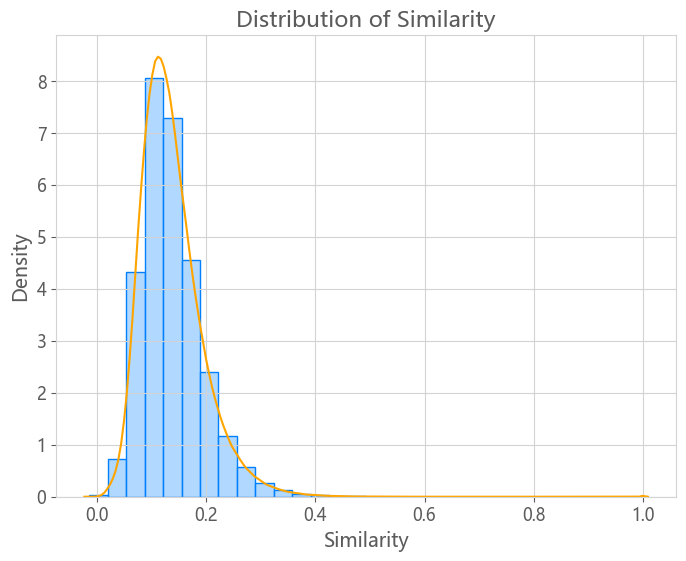

In [429]:

plt.figure(figsize=(8, 6))
sns.histplot(data = df, x = 'sim', bins = 30, 
             color = '#97CBFF', # fill & kde color
             stat = 'density',
             edgecolor = '#0080FF', linewidth = 1 )
sns.kdeplot(data = df, x = 'sim', color='orange')
plt.xlabel('Similarity', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Similarity', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

user pair: 花子怡 , 林希亚
similarity: 0.7113459998523709


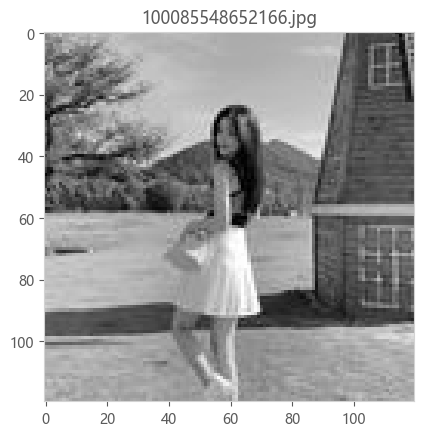

None


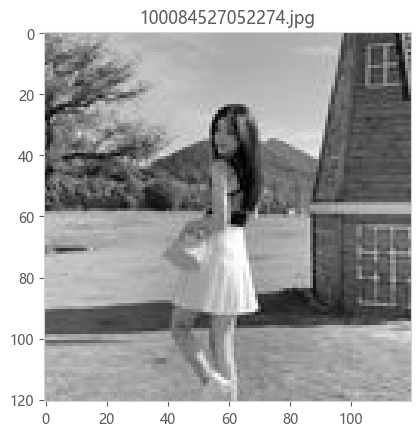

None
user pair: 花子怡 , 林小雅
similarity: 0.7113459998523709


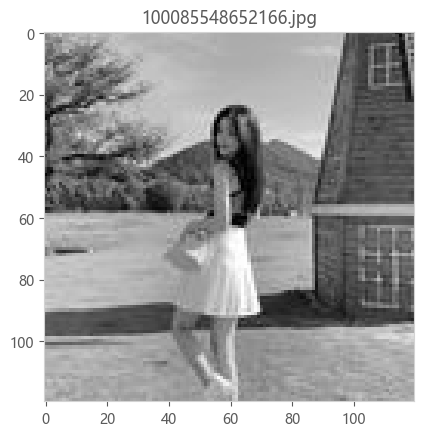

None


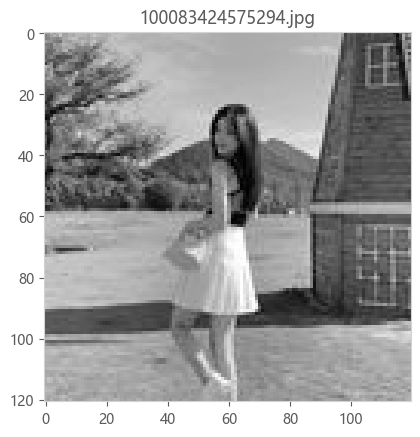

None
user pair: 林子怡 , 花子怡
similarity: 0.7113459998523709


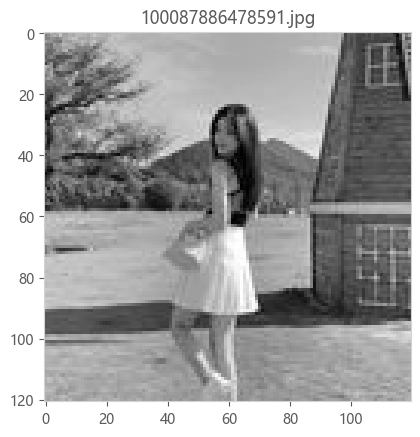

None


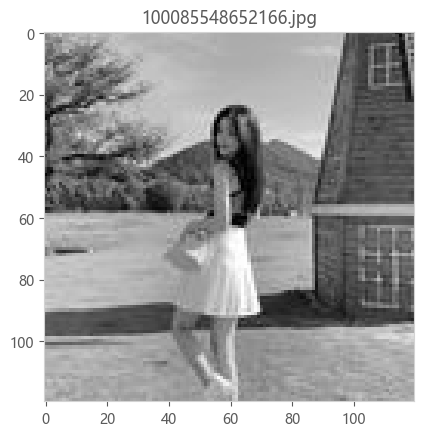

None
user pair: 花子怡 , 许小溪
similarity: 0.7113459998523709


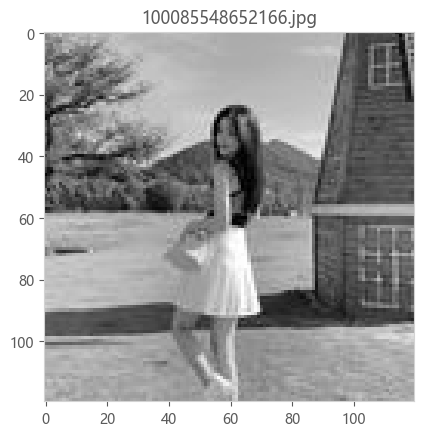

None


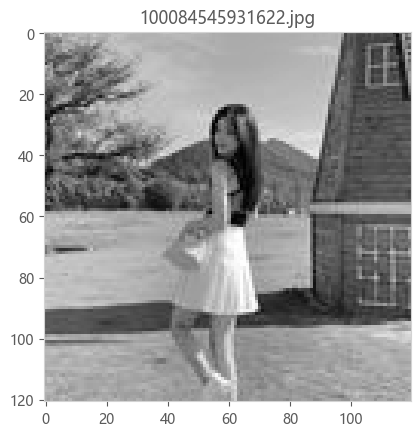

None
user pair: 花子怡 , 程小希
similarity: 0.7113459998523709


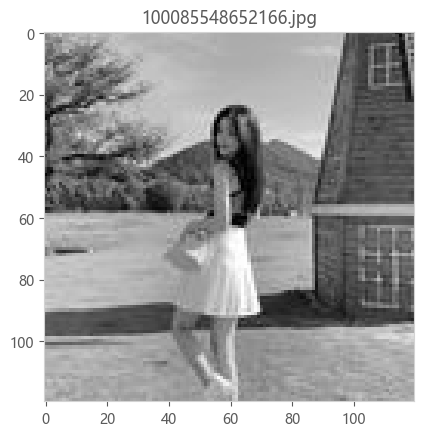

None


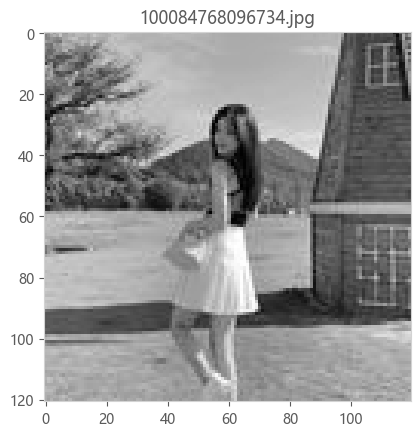

None


In [430]:
# Inspect the actual situations of user pair images within the specified similarity interval
df_filter = df.loc[(df['sim']>0.7) & (df['sim']<0.8)].sort_values('sim')

for i in range(len(df_filter.iloc[:5])):
    user_i = df_filter['user_i'].iloc[i]
    user_j = df_filter['user_j'].iloc[i]
    sim = df_filter['sim'].iloc[i]
    print('user pair:', url_id_to_name[user_i],',', url_id_to_name[user_j])
    print('similarity:', sim)
    get_image(user_i)
    get_image(user_j)

In [431]:
df_filter = df.loc[df['sim']>0.7]

In [432]:
all_users = np.union1d(df_filter['user_i'].unique(),df_filter['user_j'].unique())
print('The number of users after filtering:',len(all_users))

user_to_code = {user:code for code, user in enumerate(all_users)}
code_to_user = {code:user for code, user in enumerate(all_users)}

df_filter['user_i_code'] = df_filter['user_i'].apply(lambda v: user_to_code[v])
df_filter['user_j_code'] = df_filter['user_j'].apply(lambda v: user_to_code[v])
links = [tuple(r) for r in df_filter[['user_i_code', 'user_j_code']].to_numpy()]

The number of users after filtering: 195


C:\Users\shihy\AppData\Local\Temp\ipykernel_7416\2917331896.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['user_i_code'] = df_filter['user_i'].apply(lambda v: user_to_code[v])
C:\Users\shihy\AppData\Local\Temp\ipykernel_7416\2917331896.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['user_j_code'] = df_filter['user_j'].apply(lambda v: user_to_code[v])


In [433]:
im = Infomap('--two-level', silent=True)
im.add_links(links)
im.run()

grouping_result = {
            'user':[],
            'group':[],
        }

for node in im.nodes:
    grouping_result['user'].append(code_to_user[node.node_id])
    grouping_result['group'].append(node.module_id)
grouping_result = pd.DataFrame(grouping_result)



In [434]:
# Filtering based on group size
aim_group = grouping_result['group'].value_counts()[grouping_result['group'].value_counts() > 5].index
grouping_result = grouping_result.loc[grouping_result['group'].isin(aim_group)]
grouping_result
aim_user = grouping_result['user']

In [435]:
grouping_result['group'].value_counts()

group
1     9
2     9
3     7
4     7
5     7
6     7
7     6
8     6
9     6
10    6
11    6
Name: count, dtype: int64

许心怡


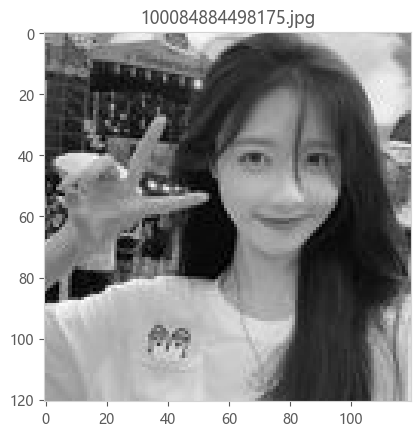

None
许小雅


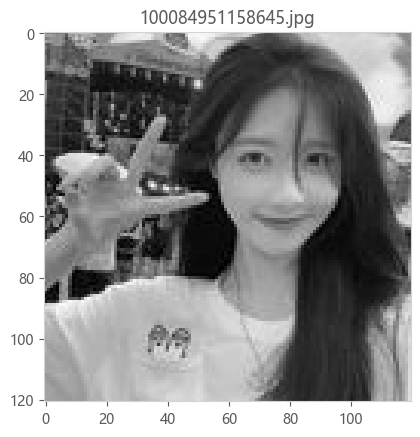

None
许新雅


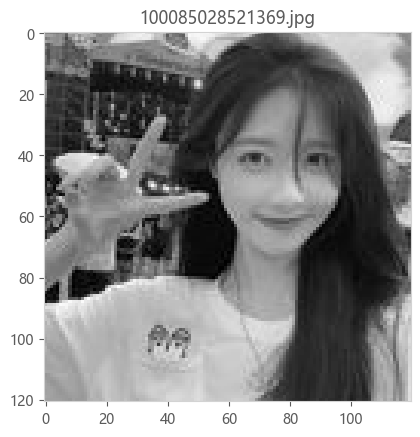

None
许小雅


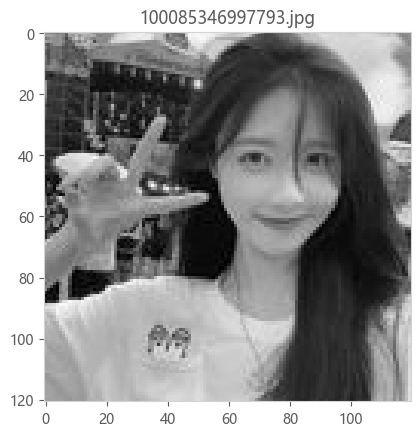

None
林子怡


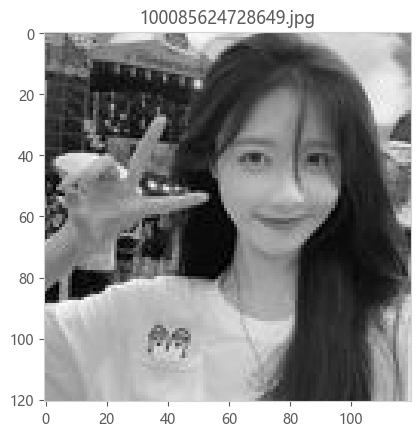

None
林小雅


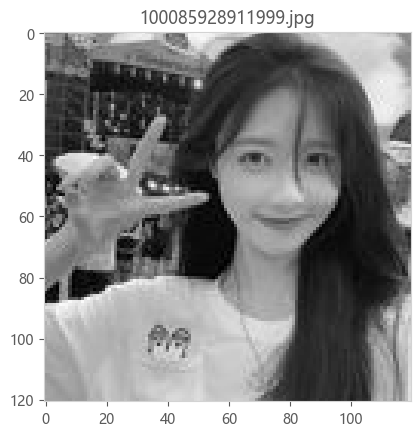

None


In [436]:
# Inspecting the actual situations of user images within the specified group
for i in grouping_result.loc[grouping_result['group'] == 9]['user']:
    print(url_id_to_name[i])
    get_image(i)

In [437]:
grouping_result['name'] = grouping_result['user'].apply(lambda v:url_id_to_name[v])
grouping_result['code'] = grouping_result['user'].apply(lambda v:user_to_code[v])
code_to_group = grouping_result.set_index('code')['group'].to_dict()
# code_to_name = grouping_result.set_index('code')['name'].to_dict()

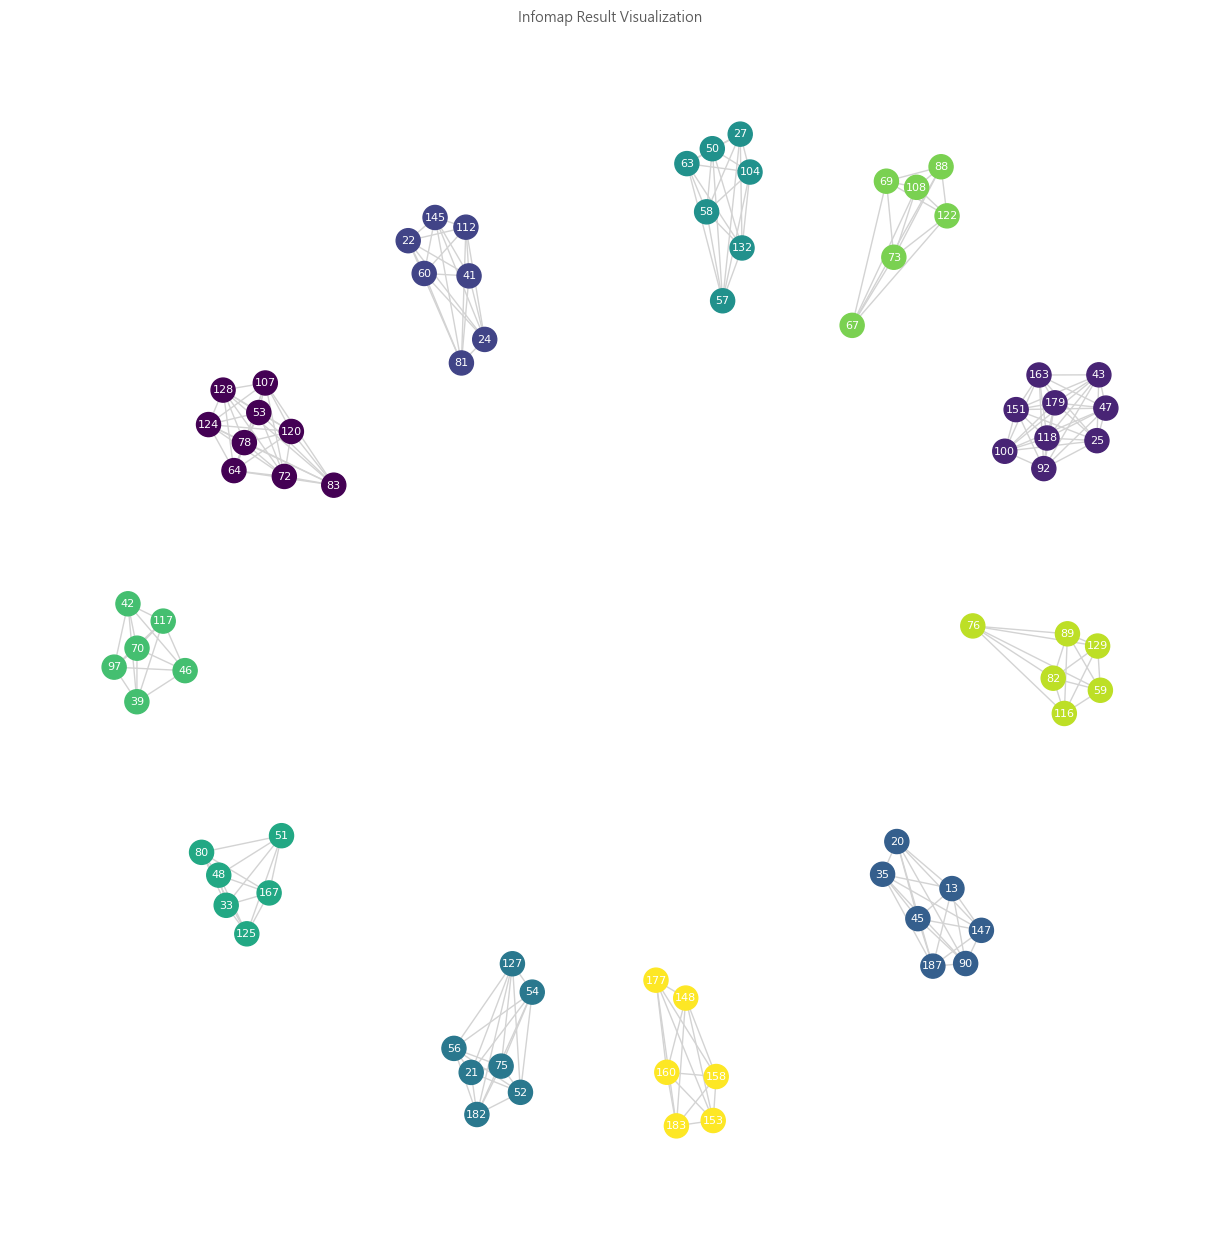

In [439]:
G = nx.Graph()
# G.add_nodes_from(code_to_user.keys())
G.add_nodes_from(grouping_result['code'])
# Discard edges in links that do not belong to any elements in G.nodes
filtered_links = [(source, target) for source, target in links if source in G.nodes and target in G.nodes]
G.add_edges_from(filtered_links)


plt.figure(figsize=(12, 12))
# Layout the network graph using the spring layout algorithm
pos = nx.spring_layout(G, k = 0.5, iterations = 76, dim = 2)

nx.draw(G, pos, 
        with_labels = True, 
        # labels = code_to_name,
        node_color = [code_to_group[node] for node in G.nodes()], # If no color map is provided, it will default to continuous variable processing
        node_size = 300, 
        font_size = 8, 
        font_color = '#FFFFFF',
        edge_color=['lightgrey' for edge in G.edges()],
        )

plt.title('Infomap Result Visualization', fontsize = 16, fontproperties = font_set)
plt.show()